In [1]:
from pathlib import Path
import pandas as pd
pd.set_option('max_rows', 1024)
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches
import seaborn as sns
from tqdm.auto import tqdm
sns.set_style(style="white")
sns.set_context("talk")
sns.set_palette("deep")

In [2]:
IDNET_PATH = Path(r"C:\Users\Fred\Documents\Insight\Gait Datasets\IDNet Database\IDNet_dataset")

In [3]:
def get_walk_data(user_id, walk_num, hz=60):
    """Return DataFrame of walk sensor data from IDNet individual/walk at 10ms intervals (resampled).
    Note the data may include NaN values since sensors are sampled at different frequencies or may skip measurements."""
    # Retrieve folder
    walkid = f"u{str(user_id).zfill(3)}_w{str(walk_num).zfill(3)}"
    folder = IDNET_PATH / walkid
    # For each sensor log, construct df from file
    dfs = []
    for log in folder.glob("*.log"):
        logtype = log.stem.split("_")[-1]  # accelerometer, gyroscope, etc.
        if logtype == "magnetometer":
            continue  # Skip magnetometer since not probably not useful
        df = pd.read_csv(log, sep="\t")
        # Read timestamp column as pandas Timedelta, starting from 0 ns
        df[f"{logtype}_timestamp"] = pd.to_timedelta(df[f"{logtype}_timestamp"], unit="ns")
        df = df.rename(columns={f"{logtype}_timestamp": "timestamp"})
        df = df.set_index("timestamp")
        dfs.append(df)
    merged_df = pd.concat(dfs, axis="columns")
    # Truncate each dataframe based on latest start / earliest end
    # Alternatively, truncate up to 10s from beginning and end to exclude for start/stop motions
    latest_start_time = max(merged_df.notna().idxmax().max(), merged_df.index[0] + pd.Timedelta("10s"))
    earliest_end_time = min(merged_df.notna()[::-1].idxmax().min(), merged_df.index[-1] - pd.Timedelta("10s"))
    # Sensors have different sampling freqs so resample
    merged_df = merged_df.resample(f"{round(1/hz * 1e9)}N").mean()
    merged_df = merged_df.loc[latest_start_time: earliest_end_time].copy()
    # Impute NaN values which are just resulting from a single skip
    merged_df = merged_df.fillna(method='pad', limit=3, axis=1)
    # Convert timestamp to relative times
    merged_df = merged_df.set_index(merged_df.index - merged_df.index[0])
    return merged_df

In [4]:
df = get_walk_data(3, 1)
df

,accelerometer_x_data,accelerometer_y_data,accelerometer_z_data,gravity_x_data,gravity_y_data,gravity_z_data,gyroscope_x_data,gyroscope_y_data,gyroscope_z_data,linearaccelerometer_x_data,linearaccelerometer_y_data,linearaccelerometer_z_data,rotvec_x_data,rotvec_y_data,rotvec_z_data
timestamp,,,,,,,,,,,,,,,
00:00:00,-2.108543,-8.566605,0.407181,0.046391,-9.739213,1.145575,-1.475784,0.029007,-0.486577,-0.676213,1.722519,-1.467486,-0.663411,0.038370,-0.046700
00:00:00.016666,-1.803841,-8.498444,-0.637421,0.103924,-9.759982,0.949072,-1.709951,-0.159144,-0.556208,-2.843566,0.915535,-0.228552,-0.671020,0.036619,-0.048223
00:00:00.033333,-0.590782,-8.829330,0.689728,0.175198,-9.783282,0.649032,-1.687038,0.771389,-0.342209,-1.357904,1.145248,-0.847709,-0.682340,0.036237,-0.051759
00:00:00.050000,-0.200684,-9.505050,2.484306,0.216924,-9.798564,0.329357,-1.643972,1.802124,-0.213720,-0.522788,0.346807,1.971531,-0.693711,0.044312,-0.061680
00:00:00.066666,-0.519356,-9.894890,2.337372,0.238562,-9.802806,0.128560,-1.555608,1.829402,-0.205994,-0.410317,-0.007471,2.424177,-0.700408,0.053550,-0.071495
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
00:09:39.983344,7.229042,-1.279419,0.817696,-0.371140,-9.052018,3.754011,0.450857,1.512975,0.287165,8.427373,8.193684,-1.983351,-0.175096,0.527193,-0.777721
00:09:40.000011,2.513390,-4.547607,-6.250519,-0.384197,-9.057591,3.739186,-0.390175,-0.147633,0.015739,5.237341,6.236277,-6.310817,-0.172930,0.528627,-0.778202
00:09:40.016678,0.589638,-9.551704,-10.052117,-0.297621,-9.125227,3.578716,-0.847000,-0.394526,-0.659648,1.133700,1.429588,-13.254145,-0.180205,0.533904,-0.773702


In [5]:
# Sample sequences from walk
def generate_walk_chunks(df, chunksize=256, is_valid=True):
    """Split df into multiple chunks of data. If is_valid is True, only yields non-NAN data (e.g. ignores sensor skips).
    Chunk size recommended to be power-of-2 for downstream FFT: https://www.oreilly.com/library/view/elegant-scipy/9781491922927/ch04.html
    """
    count = 0
    while count < (len(df) - chunksize):
        subdf = df.iloc[count:count + chunksize, :]
        if not subdf.isna().any(axis=None):  # Return only non-NA
            yield subdf
        count += chunksize

In [6]:
chunk_generator = generate_walk_chunks(df)

In [7]:
chunk = next(chunk_generator)

In [8]:
def plot_log(df, logtype):
    f, ax = plt.subplots(figsize=(15, 5))
    df = df[[f"{logtype}_x_data",f"{logtype}_y_data",f"{logtype}_z_data"]].copy()
    df["mag"] = np.linalg.norm(df.values, axis=1)
    df.plot.line(y=[f"{logtype}_x_data",f"{logtype}_y_data",f"{logtype}_z_data", "mag"], ax=ax)
    ax.set_ylabel(f"{logtype}")
    ax.set_xlabel("Time")
    ax.legend(["x", "y", "z", "mag"], loc="best")
    sns.despine()

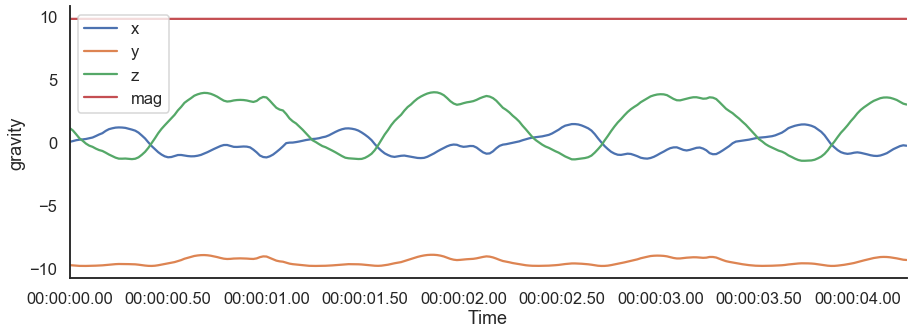

In [9]:
plot_log(chunk, "gravity")

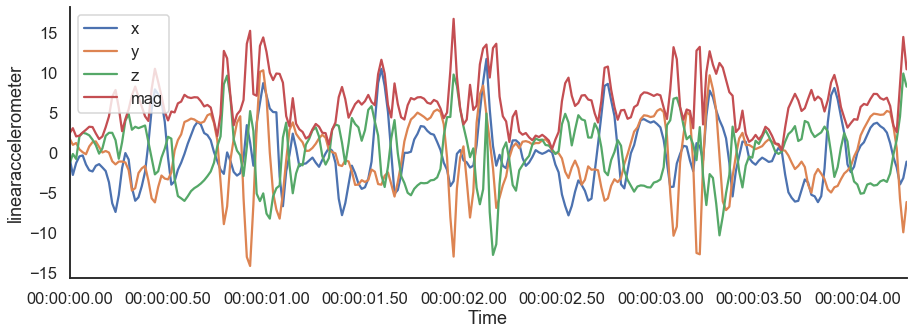

In [10]:
plot_log(chunk, "linearaccelerometer")

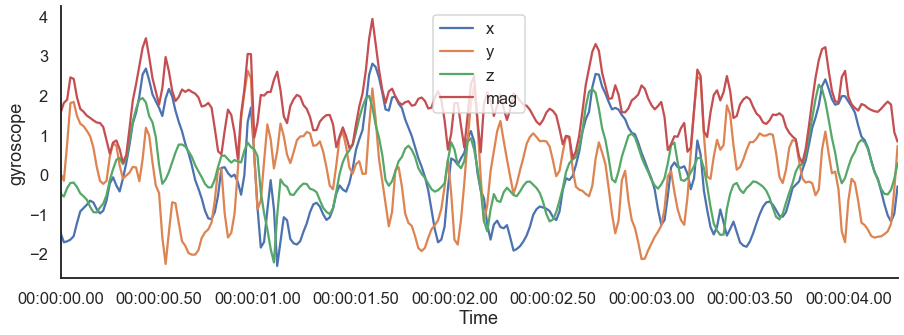

In [11]:
plot_log(chunk, "gyroscope")

## Fourier analysis

In [12]:
def get_normalized_sensor_data(df, logtype):
    norm_acc = np.linalg.norm(df[[f"{logtype}_x_data", f"{logtype}_y_data", f"{logtype}_z_data"]].values, axis=1)
    norm_acc = (norm_acc - norm_acc.mean()) / (np.percentile(norm_acc, 99) - np.percentile(norm_acc, 1))
    return norm_acc

In [13]:
from scipy.fft import fft, ifft
from scipy.signal import correlate, find_peaks, spectrogram

In [14]:
f_s = 60  # Sampling rate of 60 Hz
f_s

60

In [15]:
def get_fft(signal, f_s):
    """f_s = sampling rate (measurements/second)"""
    T = 1/f_s
    N = len(signal)
    f_values = np.linspace(0.0, 1.0/(2.0*T), N//2)
    fft_values_ = fft(signal)
    fft_values = 2.0/N * np.abs(fft_values_[0:N//2])  # take abs (remove phase component)
    return f_values, fft_values

In [16]:
def get_top_signal_peaks(x, y, n):
    peak_idx, peak_props = find_peaks(y, height=0)  # Specify height to force peak height computation
    peak_heights, peak_idx = zip(*sorted(zip(peak_props["peak_heights"], peak_idx), reverse=True)[:n])
    return x[list(peak_idx)], np.array(peak_heights)

In [17]:
def plot_fft(f_s, *signals):
    f, ax = plt.subplots(figsize=(15, 5))
    f_vals = []
    fft_vals = []
    for i, signal in enumerate(signals):
        f_val, fft_val = get_fft(signal, f_s)
        f_vals.append(f_val)
        fft_vals.append(fft_val)
        ax.plot(f_val, fft_val, "--" if i%2==1 else "-", label=i)
    ax.set_xlabel("Frequency (Hz)")
    ax.set_ylabel("Amplitude")
    ax.legend()
    sns.despine()
    return list(zip(f_vals, fft_vals))

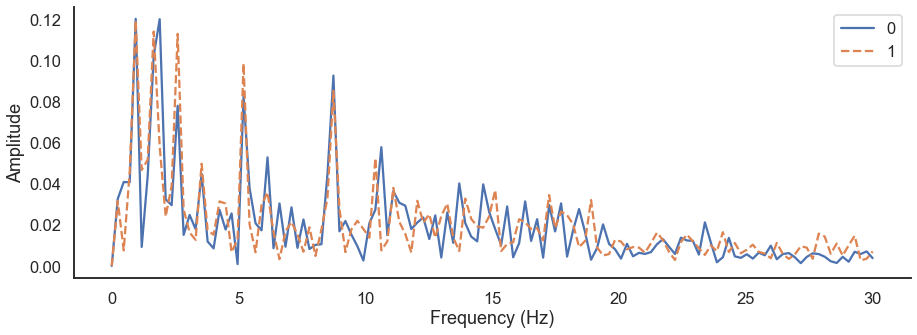

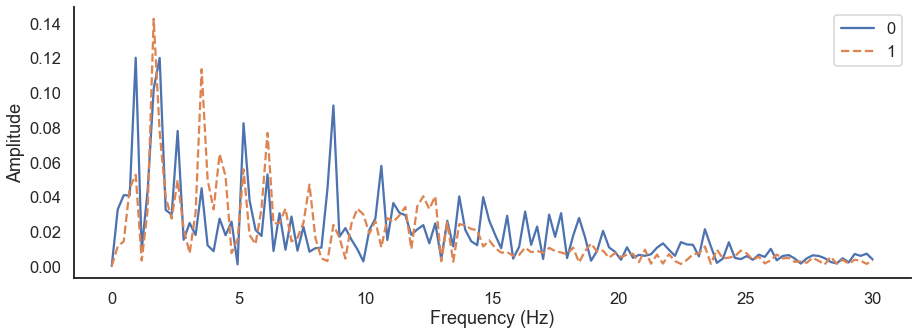

In [18]:
# plot subsequences within the same walk
norm_acc = get_normalized_sensor_data(chunk, "linearaccelerometer")
norm_gyro = get_normalized_sensor_data(chunk, "gyroscope")
next_chunk = next(chunk_generator)
(f1, fft1), (f2, fft2) = plot_fft(f_s, norm_acc, get_normalized_sensor_data(next_chunk, "linearaccelerometer"))
(f1, fft1), (f2, fft2) = plot_fft(f_s, norm_acc, get_normalized_sensor_data(next_chunk, "gyroscope"))

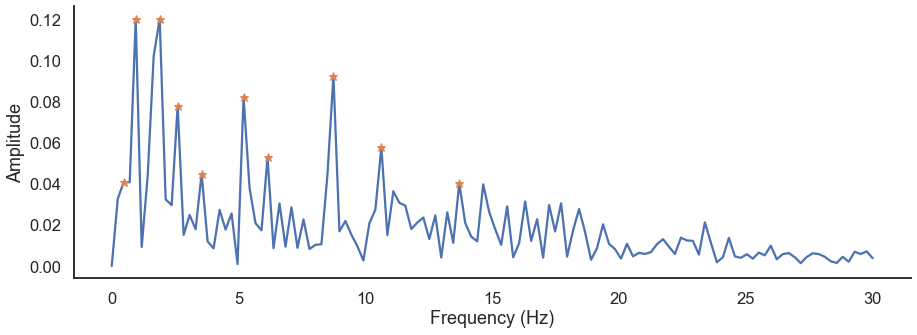

In [19]:
f, ax = plt.subplots(figsize=(15, 5))
f_val, fft_val = get_fft(norm_acc, f_s)
ax.plot(f_val, fft_val)
ax.plot(*get_top_signal_peaks(f_val, fft_val, 10), "*")
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("Amplitude")
sns.despine()

In [20]:
# checking that frequencies are unchanging across the entire walk recording
freq, time, Sxx = spectrogram(get_normalized_sensor_data(df, "linearaccelerometer"), f_s)

Text(0.5, 0, 'Time (sec)')

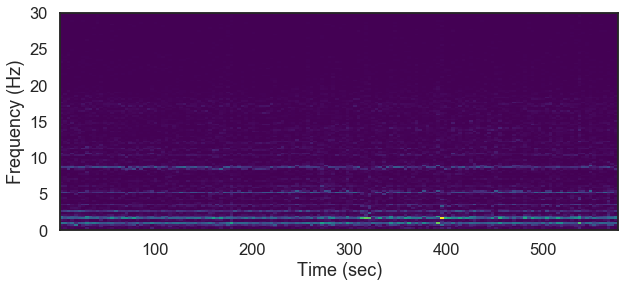

In [21]:
f, ax = plt.subplots(figsize=(10, 4))
ax.pcolormesh(time, freq, Sxx, cmap="viridis")
ax.set_ylabel("Frequency (Hz)")
ax.set_xlabel("Time (sec)")

## Convert data to feature vectors

- Iterate over users
- Chunk recording information and convert to feature (linearaccelerometer + gyroscope data)
- Label feature with user and walk number

In [22]:
# Get number of walks per user
counts = {}
for folder in IDNET_PATH.glob("*"):
    user_id = int(folder.stem[1:4])
    if user_id not in counts:
        counts[user_id] = 1
    else:
        counts[user_id] += 1

In [23]:
users_with_multiple_walks = [user for user, count in counts.items() if count > 1]
len(users_with_multiple_walks)

31

In [24]:
def create_features_from_fft_peaks(n_peaks=10):
    """Create DataFrame of feature vectors using Fourier peaks."""
    features = []
    for user in tqdm(users_with_multiple_walks, desc="User"):
        for walk in range(1, counts[user]+1):
            df = get_walk_data(user, walk)
            for chunk in generate_walk_chunks(df):
                norm_acc = get_normalized_sensor_data(chunk, "linearaccelerometer")
                norm_gyro = get_normalized_sensor_data(chunk, "gyroscope")
                f_acc, fft_acc = get_fft(norm_acc, f_s)
                peak_f_acc, peak_fft_acc = get_top_signal_peaks(f_acc, fft_acc, n_peaks)
                f_gyro, fft_gyro = get_fft(norm_gyro, f_s)
                peak_f_gyro, peak_fft_gyro = get_top_signal_peaks(f_gyro, fft_gyro, n_peaks)
                # concatenate the features
                feature_vector = np.concatenate([[user, walk], peak_f_acc, peak_fft_acc, peak_f_gyro, peak_fft_gyro])
                features.append(feature_vector)

    df_features = pd.DataFrame(features, 
        columns=["user_id", "walk_id", 
               *[f"acc_f{i}" for i in range(n_peaks)], *[f"acc_fft{i}" for i in range(n_peaks)],
               *[f"gyro_f{i}" for i in range(n_peaks)], *[f"gyro_fft{i}" for i in range(n_peaks)]
    ])
    df_features["user_id"] = df_features["user_id"].astype(int)
    df_features["walk_id"] = df_features["walk_id"].astype(int)
    return df_features

In [25]:
def create_features_from_fft_raw():
    """Create DataFrame of feature vectors using raw Fourier spectrum."""
    features = []
    for user in tqdm(users_with_multiple_walks, desc="User"):
        for walk in range(1, counts[user]+1):
            df = get_walk_data(user, walk)
            for chunk in generate_walk_chunks(df):
                norm_acc = get_normalized_sensor_data(chunk, "linearaccelerometer")
                norm_gyro = get_normalized_sensor_data(chunk, "gyroscope")
                f_acc, fft_acc = get_fft(norm_acc, f_s)
                f_gyro, fft_gyro = get_fft(norm_gyro, f_s)
                # concatenate the features
                feature_vector = np.concatenate([[user, walk], fft_acc, fft_gyro])
                features.append(feature_vector)

    df_features = pd.DataFrame(features, 
        columns=["user_id", "walk_id", 
               *[f"acc_fft{i}" for i in range(len(fft_gyro))],
               *[f"gyro_fft{i}" for i in range(len(fft_gyro))],
    ])
    df_features["user_id"] = df_features["user_id"].astype(int)
    df_features["walk_id"] = df_features["walk_id"].astype(int)
    return df_features

In [26]:
# df_features = create_features_from_fft_raw()
df_features = create_features_from_fft_peaks(5)  # I get better accuracy using peaks as features (less overfitting)

In [27]:
df_features.head()

,user_id,walk_id,acc_f0,acc_f1,acc_f2,acc_f3,acc_f4,acc_fft0,acc_fft1,acc_fft2,...,gyro_f0,gyro_f1,gyro_f2,gyro_f3,gyro_f4,gyro_fft0,gyro_fft1,gyro_fft2,gyro_fft3,gyro_fft4
0,1,1,0.944882,8.976378,1.889764,4.488189,2.598425,0.090555,0.087278,0.080766,...,0.944882,1.889764,3.543307,5.433071,6.850394,0.151417,0.142953,0.085368,0.056195,0.054701
1,1,1,1.889764,0.944882,4.488189,2.598425,8.976378,0.099350,0.086086,0.078552,...,0.944882,1.889764,3.543307,4.488189,2.834646,0.142266,0.105213,0.072058,0.057497,0.054393
2,1,1,1.889764,0.944882,4.488189,2.598425,8.740157,0.079624,0.071451,0.054809,...,0.944882,1.889764,2.598425,3.307087,6.614173,0.181698,0.113013,0.062477,0.057288,0.052231
3,1,1,1.653543,2.598425,4.488189,8.740157,6.141732,0.089051,0.078724,0.063101,...,0.944882,2.598425,1.653543,3.543307,6.377953,0.154115,0.081443,0.079212,0.077008,0.051798
4,1,1,1.889764,2.834646,0.944882,4.724409,9.212598,0.096984,0.096650,0.094798,...,0.944882,1.889764,2.834646,3.779528,4.724409,0.137839,0.120427,0.094476,0.066042,0.051848


## Fit data to initial classification model

- Make sure when splitting into training/test data that we don't mix walks in either set (leakage)
- This is just to test if the individuals can indeed be resolved

In [28]:
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier

In [29]:
train = df_features[df_features["walk_id"] == 1].copy()
y_train, X_train = train.iloc[:, 0], train.iloc[:, 2:]
test = df_features[df_features["walk_id"] != 1].copy()
y_test, X_test = test.iloc[:, 0], test.iloc[:, 2:]

#### random forest

In [30]:
trees = RandomForestClassifier(class_weight="balanced")

In [31]:
trees.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [32]:
train["predicted_user"] = trees.predict(X_train)
test["predicted_user"] = trees.predict(X_test)

Text(0.5, 1.0, 'Training set confusion matrix')

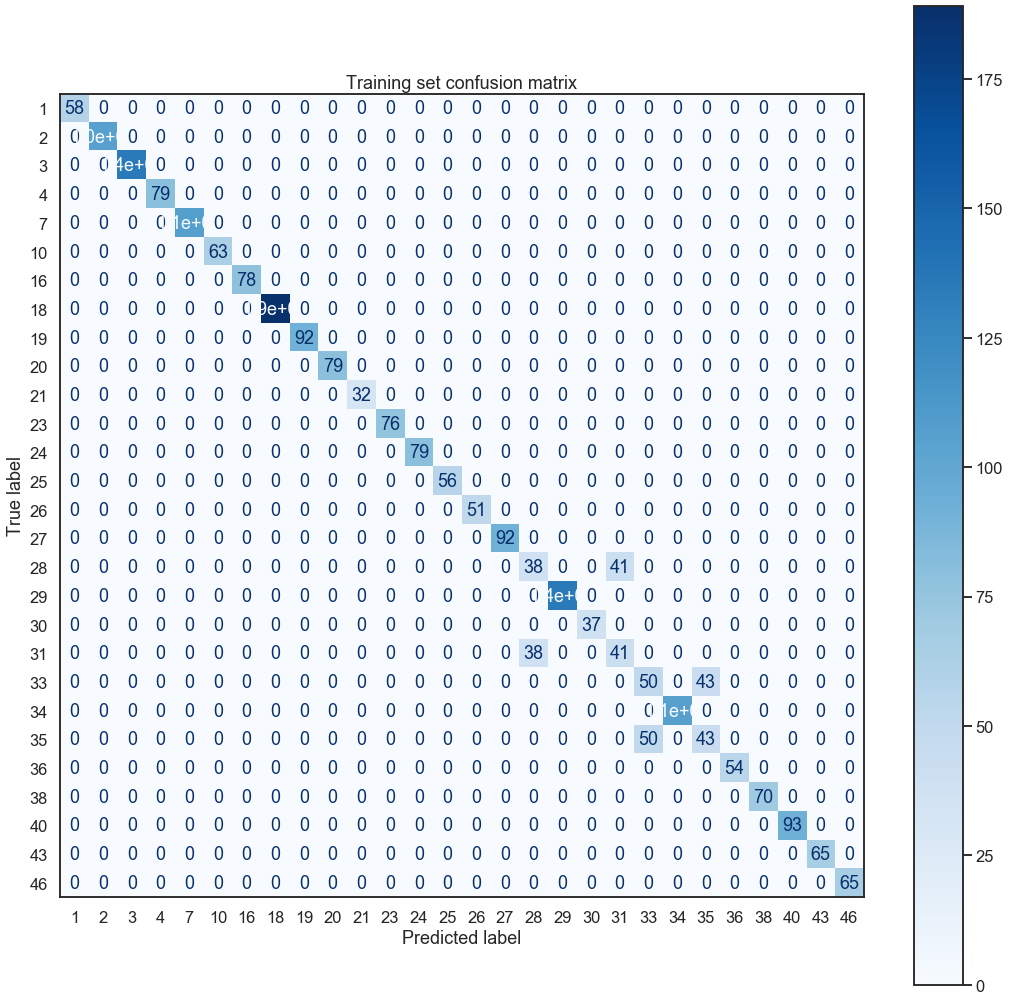

In [33]:
f, ax = plt.subplots(figsize=(18,18))
metrics.plot_confusion_matrix(trees, X_train, y_train, ax=ax, cmap="Blues")
ax.set_title("Training set confusion matrix")
# ax.images[-1].colorbar.remove()

In [34]:
metrics.accuracy_score(y_train, train["predicted_user"])

0.9264957264957265

Text(0.5, 1.0, 'Test set confusion matrix')

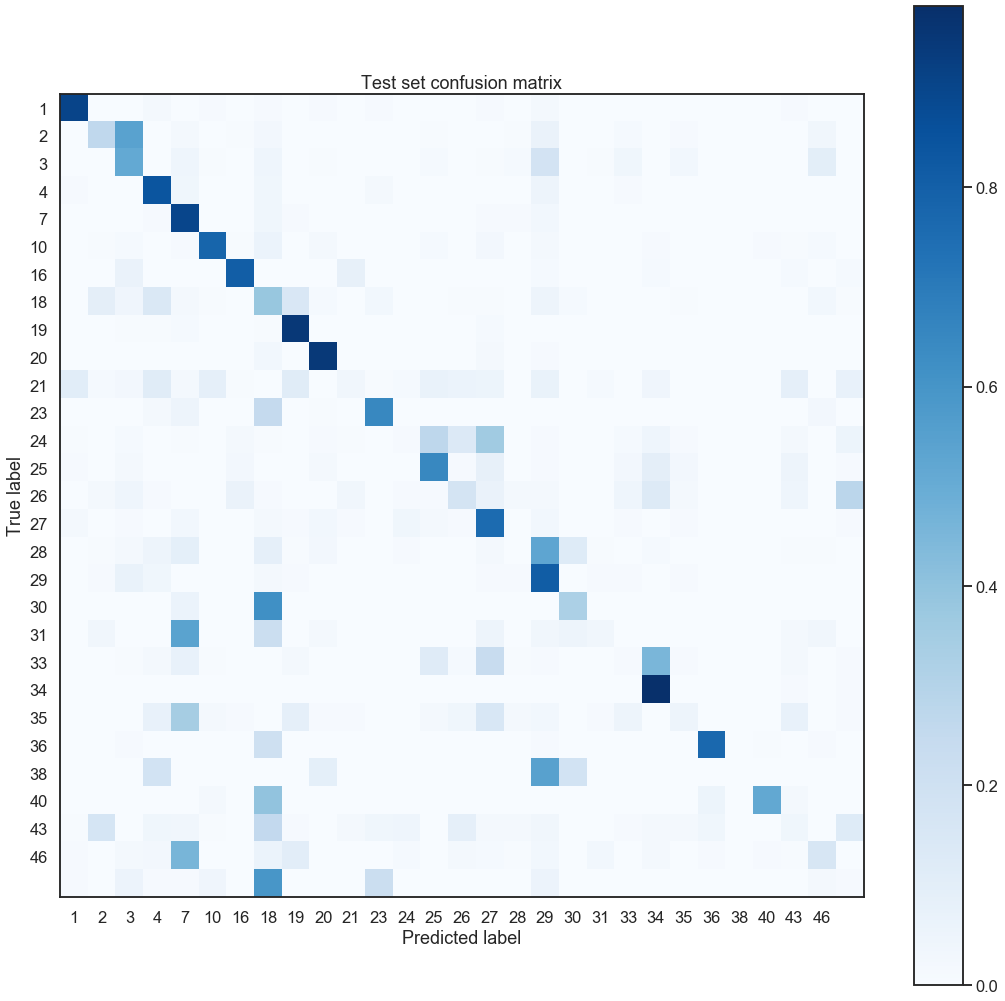

In [35]:
f, ax = plt.subplots(figsize=(18,18))
metrics.plot_confusion_matrix(trees, X_test, y_test, ax=ax, cmap="Blues", normalize="true", include_values=False)
ax.set_title("Test set confusion matrix")

In [36]:
# report accuracy
cm = metrics.confusion_matrix(y_test, test["predicted_user"])

In [37]:
trues = 0
for i, row in enumerate(cm):
    if row.argmax() == i:
        trues += 1

In [38]:
print(f"Pooled accuracy per-user {trues / len(cm)}")

Pooled accuracy per-user 0.5517241379310345


In [39]:
print(f"Accuracy: {cm.trace() / cm.sum():.2%}")

Accuracy: 39.12%


In [40]:
metrics.balanced_accuracy_score(y_test, test["predicted_user"])

0.4565191491313736

In [41]:
print(metrics.balanced_accuracy_score(y_test, test["predicted_user"]) / (1/len(cm)))

13.239055324809835


In [42]:
np.triu(cm,1).sum(), np.tril(cm,-1).sum()

(2183, 2153)

In [43]:
metrics.precision_score(y_test, test["predicted_user"], average="micro")

0.39118225217635494

In [44]:
from sklearn.manifold import MDS

def plot_embeddings_mds(embeddings, labels):
    mds = MDS()
    embeddings_mds = mds.fit_transform(embeddings)
    f, ax = plt.subplots(figsize=(15, 15))
    sns.scatterplot(x=embeddings_mds[:,0], y=embeddings_mds[:,1], 
                    hue="user=" + pd.Series(labels).astype(int).astype(str),
                    ax=ax)

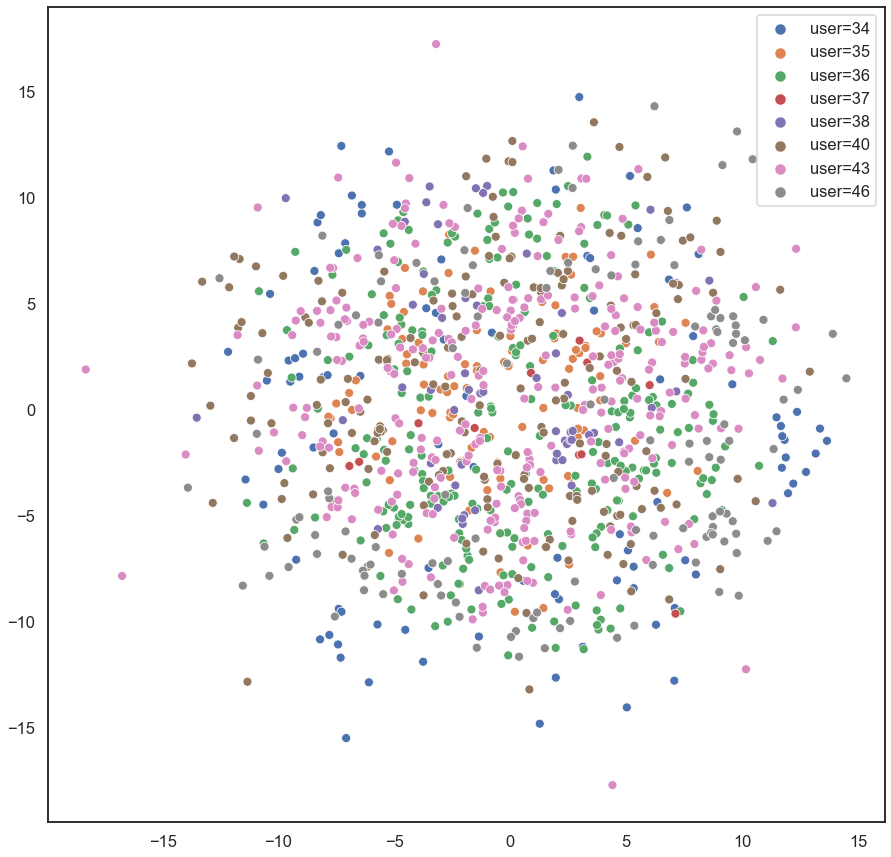

In [45]:
plot_embeddings_mds(X_test.iloc[6000:,:].values, y_test[6000:].values)

## Compute similarity scores

- basic idea for now is to normalize features and do a cosine similarity
- pool maximum similarity

In [46]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances

In [47]:
# Need to normalize across features
# scaler = MinMaxScaler(feature_range=(-1,1))
scaler = StandardScaler()

In [48]:
scaled_features = scaler.fit_transform(df_features.iloc[:,2:])  # features should be columns

In [49]:
multiindex = df_features.set_index(["user_id", "walk_id"]).index
normed = pd.DataFrame(scaled_features, columns=df_features.columns[2:], index=multiindex)
normed.head()

acc_f0    acc_f1    acc_f2    acc_f3    acc_f4  acc_fft0  \
user_id walk_id                                                               
1       1       -0.241551  2.332334 -1.299207 -0.694650 -1.297295 -2.146897   
        1        1.088809 -0.774548 -0.477421 -1.286120  0.567514 -1.767583   
        1        1.088809 -0.774548 -0.477421 -1.286120  0.498447 -2.618332   
        1        0.756219 -0.134895 -0.477421  0.636156 -0.261290 -2.211780   
        1        1.088809 -0.043517 -1.598039 -0.620716  0.636581 -1.869624   

                 acc_fft1  acc_fft2  acc_fft3  acc_fft4  gyro_f0   gyro_f1  \
user_id walk_id                                                              
1       1       -0.639626  0.209689  0.595094  0.469929 -1.45407 -0.612254   
        1       -0.707626  0.051985  0.806876  1.576526 -1.45407 -0.612254   
        1       -1.542576 -1.639694 -1.243963 -1.650264 -1.45407 -0.612254   
        1       -1.127640 -1.048911 -0.515671 -0.929378 -1.45407 -0.223330   
        1       -0.104892  1.209466 -0.214380  0.105143 -1.45407 -0.612254   

                  gyro_f2   gyro_f3   gyro_f4  gyro_fft0  gyro_fft1  \
user_id walk_id                                                       
1       1       -0.119204  0.271010  0.432709  -0.639380   1.403790   
        1       -0.119204 -0.074839 -0.930451  -0.855305  -0.314043   
        1       -0.546764 -0.507150  0.352523   0.075150   0.040977   
        1       -0.974324 -0.420688  0.272337  -0.575726  -1.395988   
        1       -0.439874 -0.334225 -0.288964  -0.959783   0.378445   

                 gyro_fft2  gyro_fft3  gyro_fft4  
user_id walk_id                                   
1       1        -0.269508  -1.426469  -0.907592  
        1        -1.055971  -1.324466  -0.936128  
        1        -1.622057  -1.340870  -1.136443  
        1        -0.633264   0.203522  -1.176559  
        1         0.268682  -0.655234  -1.171890

In [50]:
# Using euclidean distances instead... (normalize simi by 1/1+d?)
# simi = pd.DataFrame(euclidean_distances(df_features.iloc[:,2:].set_index(multiindex)), index=multiindex, columns=multiindex)

In [51]:
simi = pd.DataFrame(cosine_similarity(normed), index=multiindex, columns=multiindex)
# understand why values are negative here

In [52]:
simi.head()

user_id                1                                                     \
walk_id                 1         1         1         1         1         1   
user_id walk_id                                                               
1       1        1.000000  0.452450  0.367520  0.314397  0.582565  0.480366   
        1        0.452450  1.000000  0.546046  0.420782  0.695536  0.526648   
        1        0.367520  0.546046  1.000000  0.749369  0.510454  0.815944   
        1        0.314397  0.420782  0.749369  1.000000  0.484558  0.746627   
        1        0.582565  0.695536  0.510454  0.484558  1.000000  0.697801   

user_id                                                  ...        46  \
walk_id                 1         1         1         1  ...         3   
user_id walk_id                                          ...             
1       1        0.556738  0.526434  0.408330  0.361511  ...  0.464418   
        1        0.627788  0.611249  0.623421  0.696914  ...  0.279516   
        1        0.654405  0.817000  0.427327  0.865322  ...  0.265092   
        1        0.562880  0.551566  0.360670  0.670586  ...  0.009447   
        1        0.375894  0.638877  0.601913  0.677720  ...  0.177834   

user_id                                                                      \
walk_id                 3         3         3         3         3         3   
user_id walk_id                                                               
1       1        0.491074  0.574831  0.331883  0.535352  0.445565  0.270620   
        1        0.205699  0.164626  0.324675 -0.053341  0.078699  0.086758   
        1       -0.185630 -0.095907 -0.173291 -0.245355 -0.081127 -0.552156   
        1       -0.058826  0.142949 -0.220108 -0.171162 -0.119085 -0.495709   
        1        0.067373  0.215488  0.245472 -0.034073  0.361851  0.125781   

user_id                                        
walk_id                 3         3         3  
user_id walk_id                                
1       1        0.484458  0.422259  0.219936  
        1       -0.007472 -0.208902 -0.007623  
        1       -0.051705 -0.361724 -0.522023  
        1       -0.215933 -0.139242 -0.505356  
        1        0.165716 -0.083787 -0.038387  

[5 rows x 9462 columns]

In [53]:
pd.Series(simi.loc[(2,1),(1,1)].values.ravel()).mean()

0.015478103804302885

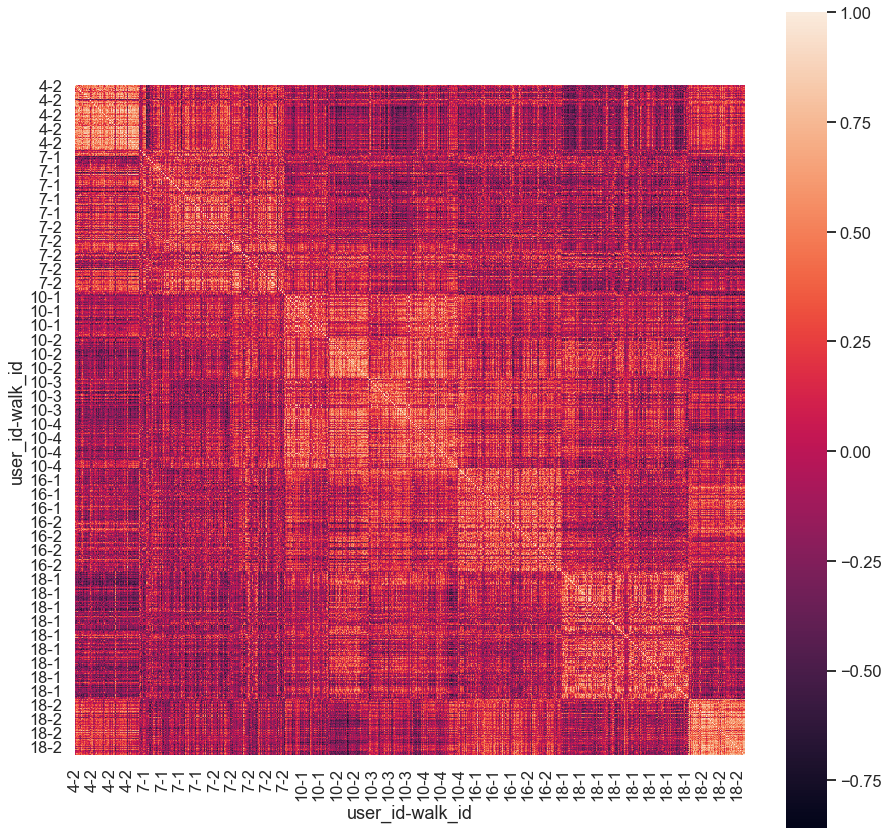

In [54]:
f, ax = plt.subplots(figsize=(15,15))
sns.heatmap(simi.iloc[1000:2000,1000:2000], square=True, ax=ax)

In [55]:
# Pool simi by mean similarity over the entire walks being compared
# Note before doing this we need to NaN the diagonal values so that they aren't counted in the mean
np.fill_diagonal(simi.values, np.nan)
pool = simi.groupby(by=["user_id", "walk_id"], axis=0).mean().groupby(by=["user_id", "walk_id"], axis=1).mean()
pool.head()

user_id                1                             2                       \
walk_id                 1         2         3         1         2         3   
user_id walk_id                                                               
1       1        0.507176  0.341378  0.376103  0.015478  0.088747 -0.032023   
        2        0.341378  0.593982  0.457615  0.132567 -0.140437  0.053262   
        3        0.376103  0.457615  0.519937  0.214350 -0.086656  0.190622   
2       1        0.015478  0.132567  0.214350  0.484192 -0.018801  0.405822   
        2        0.088747 -0.140437 -0.086656 -0.018801  0.315419 -0.069201   

user_id                          3                   4   ...        40  \
walk_id                 4         1         2         1  ...         3   
user_id walk_id                                          ...             
1       1       -0.023643  0.088747 -0.023643 -0.061275  ...  0.092774   
        2       -0.178414 -0.140437 -0.178414 -0.164387  ...  0.330268   
        3       -0.153570 -0.086656 -0.153570 -0.108550  ...  0.287264   
2       1       -0.108566 -0.018801 -0.108566 -0.048865  ...  0.277664   
        2        0.225370  0.320490  0.225370 -0.088935  ... -0.094198   

user_id                          43                                          \
walk_id                 4         1         2         3         4         5   
user_id walk_id                                                               
1       1        0.148456 -0.033974 -0.136158 -0.091359  0.019251 -0.123055   
        2        0.169509 -0.133045 -0.425727  0.018905 -0.075460 -0.215608   
        3        0.221520 -0.084135 -0.332271 -0.029484 -0.113496 -0.165313   
2       1        0.135803 -0.146648 -0.142914  0.085063 -0.073204 -0.089756   
        2       -0.105393  0.159573  0.236037 -0.114299  0.147420 -0.021054   

user_id                46                      
walk_id                 1         2         3  
user_id walk_id                                
1       1        0.174299  0.094079  0.097352  
        2        0.241952  0.122614 -0.117782  
        3        0.241417  0.162626 -0.009827  
2       1        0.196082  0.069797 -0.134098  
        2        0.029319  0.044389  0.156320  

[5 rows x 111 columns]

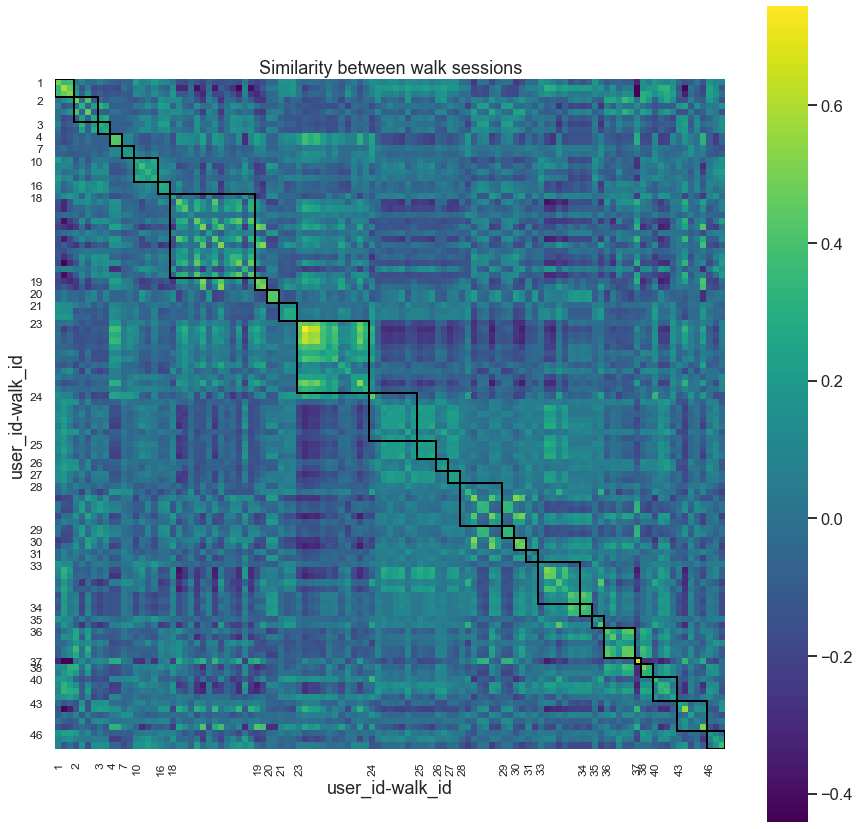

In [58]:
f, ax = plt.subplots(figsize=(15,15))
# Get indices of each user in pool and number of walks for each so we can highlight same-user groups
groups = [(pool.index.get_loc((subdf.iloc[0]["user_id"], subdf.iloc[0]["walk_id"])), len(subdf["walk_id"].unique())) 
          for user, subdf in df_features.groupby("user_id")]
# Get ticklabels
ticklabels = []
for group, group_sz in groups:
    ticklabels.append(pool.index[group][0])
    for i in range(1, group_sz):
        ticklabels.append('')

sns.heatmap(pool, square=True, ax=ax, cmap="viridis", xticklabels=ticklabels, yticklabels=ticklabels)
ax.tick_params(axis='both', which='major', labelsize=12)

# Draw boxes around each group
for group, group_sz in groups:
    rect = patches.Rectangle((group, group), group_sz, group_sz, linewidth=2, edgecolor='k', facecolor='none')
    ax.add_patch(rect)

ax.set_title("Similarity between walk sessions")
plt.show()

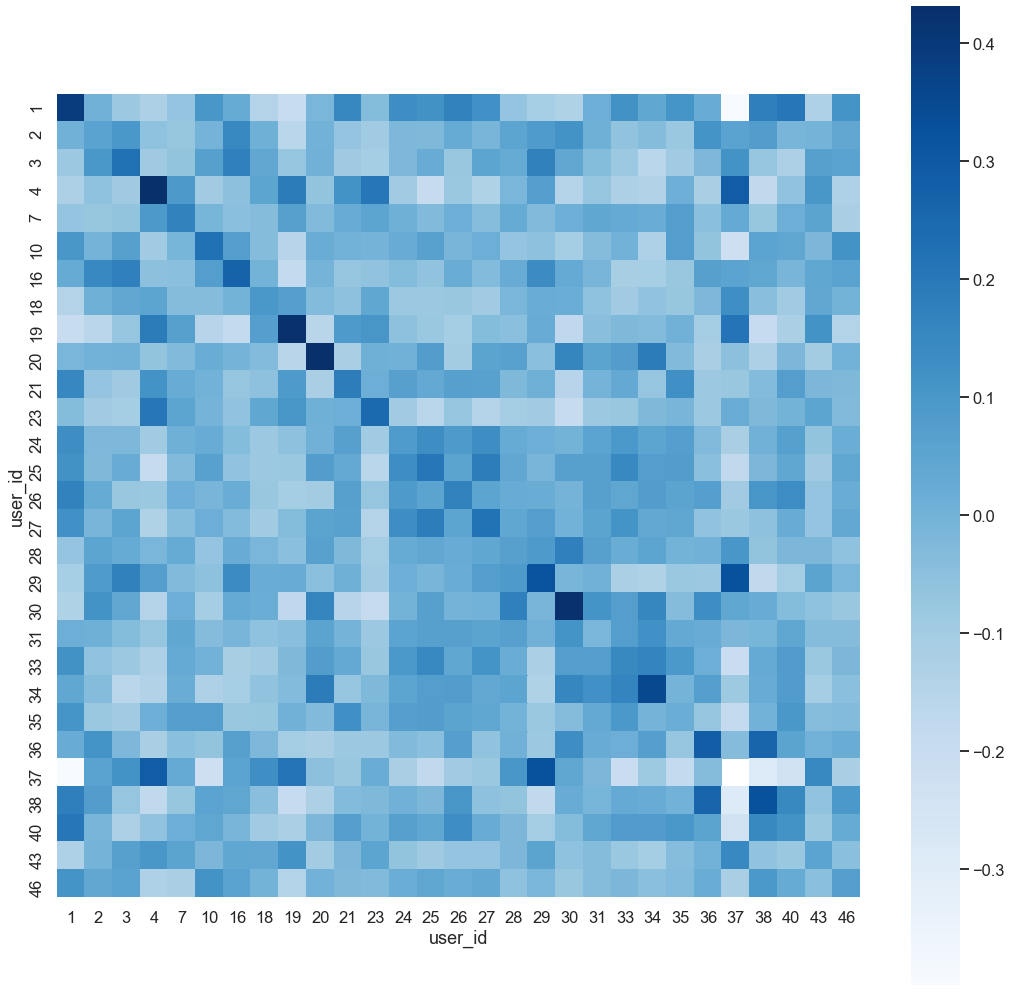

In [59]:
f, ax = plt.subplots(figsize=(18,18))
np.fill_diagonal(pool.values, np.nan)
poolpool = pool.groupby("user_id", axis=0).mean().groupby("user_id", axis=1).mean()
sns.heatmap(poolpool, square=True, cmap="Blues")